In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from pylab import *
import re
from sklearn.preprocessing import StandardScaler
import gc
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np

# matplotlit and seaborn for visualizations
plt.rcParams['font.size'] = 22

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

* Import Data Set

In [ ]:
train_df = pd.read_csv('application_train.csv')
test_df = pd.read_csv('application_test.csv')
bureau = pd.read_csv('bureau.csv')
bb = pd.read_csv('bureau_balance.csv')
prev = pd.read_csv('previous_application.csv')
pos = pd.read_csv('POS_CASH_balance.csv')
ins = pd.read_csv('installments_payments.csv')
cc = pd.read_csv('credit_card_balance.csv')

In [ ]:
# Read data and merge
print("Train samples: {}, test samples: {}".format(len(train_df), len(test_df)))
print("Train samples columns: {}, test samples columns: {}".format(len(train_df.columns), len(test_df.columns)))

Train samples: 307511, test samples: 48744
Train samples columns: 122, test samples columns: 121


* Train samples columns: 122, test samples columns: 121
* Let's find out what's the missing value in test_df

In [ ]:
li1 = np.array(test_df.columns)
li2 = np.array(train_df.columns)
 
diff = np.setdiff1d(li2, li1)
 
print(list(diff))

['TARGET']


* The missing column is called target. I suppose it's the target value against the prediction will be assessed. Let's find out.

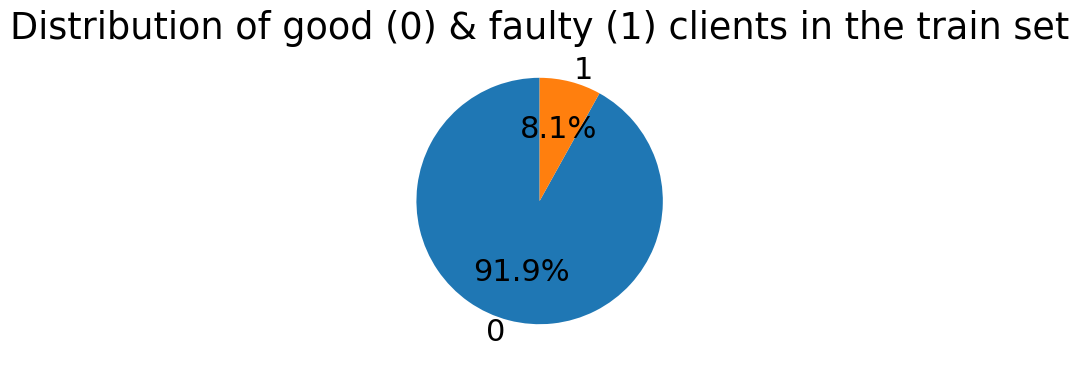

In [ ]:
value_counts = train_df.TARGET.value_counts()

plt.figure(figsize=(4, 4))
value_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Distribution of good (0) & faulty (1) clients in the train set')
plt.ylabel('')
plt.show()

# 0 - Features engineering

Source: https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features

* One-hot encoding for categorical columns with get_dummies

In [ ]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [ ]:
df = train_df.append(test_df)
#df = df.append(test_df).reset_index()
# Optional: Remove 4 applications with XNA CODE_GENDER (train set)
df = df[df['CODE_GENDER'] != 'XNA']

# Categorical features with Binary encode (0 or 1; two categories)
for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df[bin_feature], uniques = pd.factorize(df[bin_feature])
# Categorical features with One-Hot encode
df, cat_cols = one_hot_encoder(df)

# NaN values for DAYS_EMPLOYED: 365.243 -> nan
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
# Some simple new features (percentages)
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
del train_df, test_df
gc.collect()

2402

* Preprocess bureau.csv and bureau_balance.csv

In [ ]:
bb, bb_cat = one_hot_encoder(bb)
bureau, bureau_cat = one_hot_encoder(bureau)

# Bureau balance: Perform aggregations and merge with bureau.csv
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
for col in bb_cat:
    bb_aggregations[col] = ['mean']
bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
del bb, bb_agg
gc.collect()

# Bureau and bureau_balance numeric features
num_aggregations = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}
# Bureau and bureau_balance categorical features
cat_aggregations = {}
for cat in bureau_cat: cat_aggregations[cat] = ['mean']
for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
# Bureau: Active credits - using only numerical aggregations
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
del active, active_agg
gc.collect()
# Bureau: Closed credits - using only numerical aggregations
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
#bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR').reset_index()
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
#bureau_agg = bureau_agg.reset_index()

In [ ]:
bureau_agg

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,...,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,240043.666667,-1329.0,1778.0,82.428571,-93.142857,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-51.0,0.0,35.000000,140.0
100002,-1437,-103,-874.000000,186150.000000,-1072.0,780.0,-349.000000,-499.875000,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-47.0,0.0,15.000000,90.0
100003,-2586,-606,-1400.750000,827783.583333,-2434.0,1216.0,-544.500000,-816.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100004,-1326,-408,-867.000000,421362.000000,-595.0,-382.0,-488.500000,-532.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100005,-373,-62,-190.666667,26340.333333,-128.0,1324.0,439.333333,-54.333333,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-12.0,0.0,13.000000,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456249,-2713,-483,-1667.076923,407302.243590,-2499.0,1363.0,-1232.333333,-1064.538462,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
456250,-1002,-760,-862.000000,15724.000000,-272.0,2340.0,1288.333333,-60.333333,0,0.0,...,0.0,0.0,0.0,384147.0,384147.0,0.0,-32.0,0.0,33.000000,33.0
456253,-919,-713,-867.500000,10609.000000,-189.0,1113.0,280.500000,-253.250000,0,0.0,...,0.0,0.0,0.0,58369.5,58369.5,0.0,-30.0,0.0,31.000000,62.0


In [ ]:
df = df.join(bureau_agg, how='left', on='SK_ID_CURR')
del bureau, closed, closed_agg, bureau_agg
gc.collect()

0

* Preprocess previous_applications.csv

In [ ]:
prev, prev_cat_cols = one_hot_encoder(prev, nan_as_category= True)
# Days 365.243 values -> nan
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
# Add feature: value ask / value received percentage
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
# Previous applications numeric features
num_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_APPLICATION': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
}

# Previous applications categorical features
cat_aggregations = {}
for cat in prev_cat_cols:
    cat_aggregations[cat] = ['mean']

prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
# Previous Applications: Approved Applications - only numerical features
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
# Previous Applications: Refused Applications - only numerical features
refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
#prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR').reset_index()
prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')

In [ ]:
df = df.join(prev_agg, how='left', on='SK_ID_CURR')
del refused, refused_agg, approved, approved_agg, prev
gc.collect()

0

* Preprocess POS_CASH_balance.csv

In [ ]:
pos, pos_cat_cols = one_hot_encoder(pos, nan_as_category= True)
# Features
aggregations = {
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}
for cat in pos_cat_cols:
    aggregations[cat] = ['mean']

pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
# Count pos cash accounts
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
#pos_agg = pos_agg.reset_index()

In [ ]:
df = df.join(pos_agg, how='left', on='SK_ID_CURR')

del pos, pos_agg
gc.collect()

0

* Preprocess installments_payments.csv

In [ ]:
ins, ins_cat_cols = one_hot_encoder(ins, nan_as_category= True)
# Percentage and difference paid in each installment (amount paid and installment value)
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
# Days past due and days before due (no negative values)
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
# Features: Perform aggregations
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'DPD': ['max', 'mean', 'sum'],
    'DBD': ['max', 'mean', 'sum'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
}
for cat in ins_cat_cols:
    aggregations[cat] = ['mean']
ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
# Count installments accounts
ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
#ins_agg = ins_agg.reset_index()


In [ ]:
df = df.join(ins_agg, how='left', on='SK_ID_CURR')

del ins, ins_agg
gc.collect()

0

* Preprocess credit_card_balance.csv

In [ ]:
cc, cc_cat_cols = one_hot_encoder(cc, nan_as_category= True)
# General aggregations
cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
# Count credit card lines
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
#cc_agg = cc_agg.reset_index()


In [ ]:
df = df.join(cc_agg, how='left', on='SK_ID_CURR')

del cc, cc_agg
gc.collect()

0

# MERGE

df = application_train + application_test
bureau_agg = bureau + bureau_balance
prev_agg = previous_application
pos_agg = POS_CASH_balance
ins_agg = installments_payments
cc_agg = credit_card_balance

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356251 entries, 0 to 48743
Columns: 810 entries, SK_ID_CURR to CC_COUNT
dtypes: float64(622), int64(42), uint8(146)
memory usage: 1.8 GB


In [ ]:
df.TARGET

0        1.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
48739    NaN
48740    NaN
48741    NaN
48742    NaN
48743    NaN
Name: TARGET, Length: 356251, dtype: float64

## Merged data analysis

* Rename columns to remove special charecters

In [ ]:
# Function to clean column names
def clean_column_name(column_name):
    return re.sub(r'\W|^(?=\d)', '_', column_name)

# Rename columns to remove special characters
df.columns = [clean_column_name(x) for x in df.columns]
categ_cols = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY'] + cat_cols + bureau_cat + bb_cat + prev_cat_cols + pos_cat_cols + ins_cat_cols + cc_cat_cols

In [ ]:
df.isna().sum().sort_values(ascending=False) / df.sum()

ACTIVE_AMT_ANNUITY_MAX                1.067438e-04
ACTIVE_AMT_ANNUITY_MEAN               1.549292e-04
ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN    6.418332e-04
ACTIVE_AMT_CREDIT_SUM_DEBT_MAX        7.463326e-07
ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN       1.270363e-06
                                          ...     
YEARS_BEGINEXPLUATATION_MEDI          9.638964e-01
YEARS_BEGINEXPLUATATION_MODE          9.645521e-01
YEARS_BUILD_AVG                       2.618788e+00
YEARS_BUILD_MEDI                      2.607470e+00
YEARS_BUILD_MODE                      2.594066e+00
Length: 810, dtype: float64

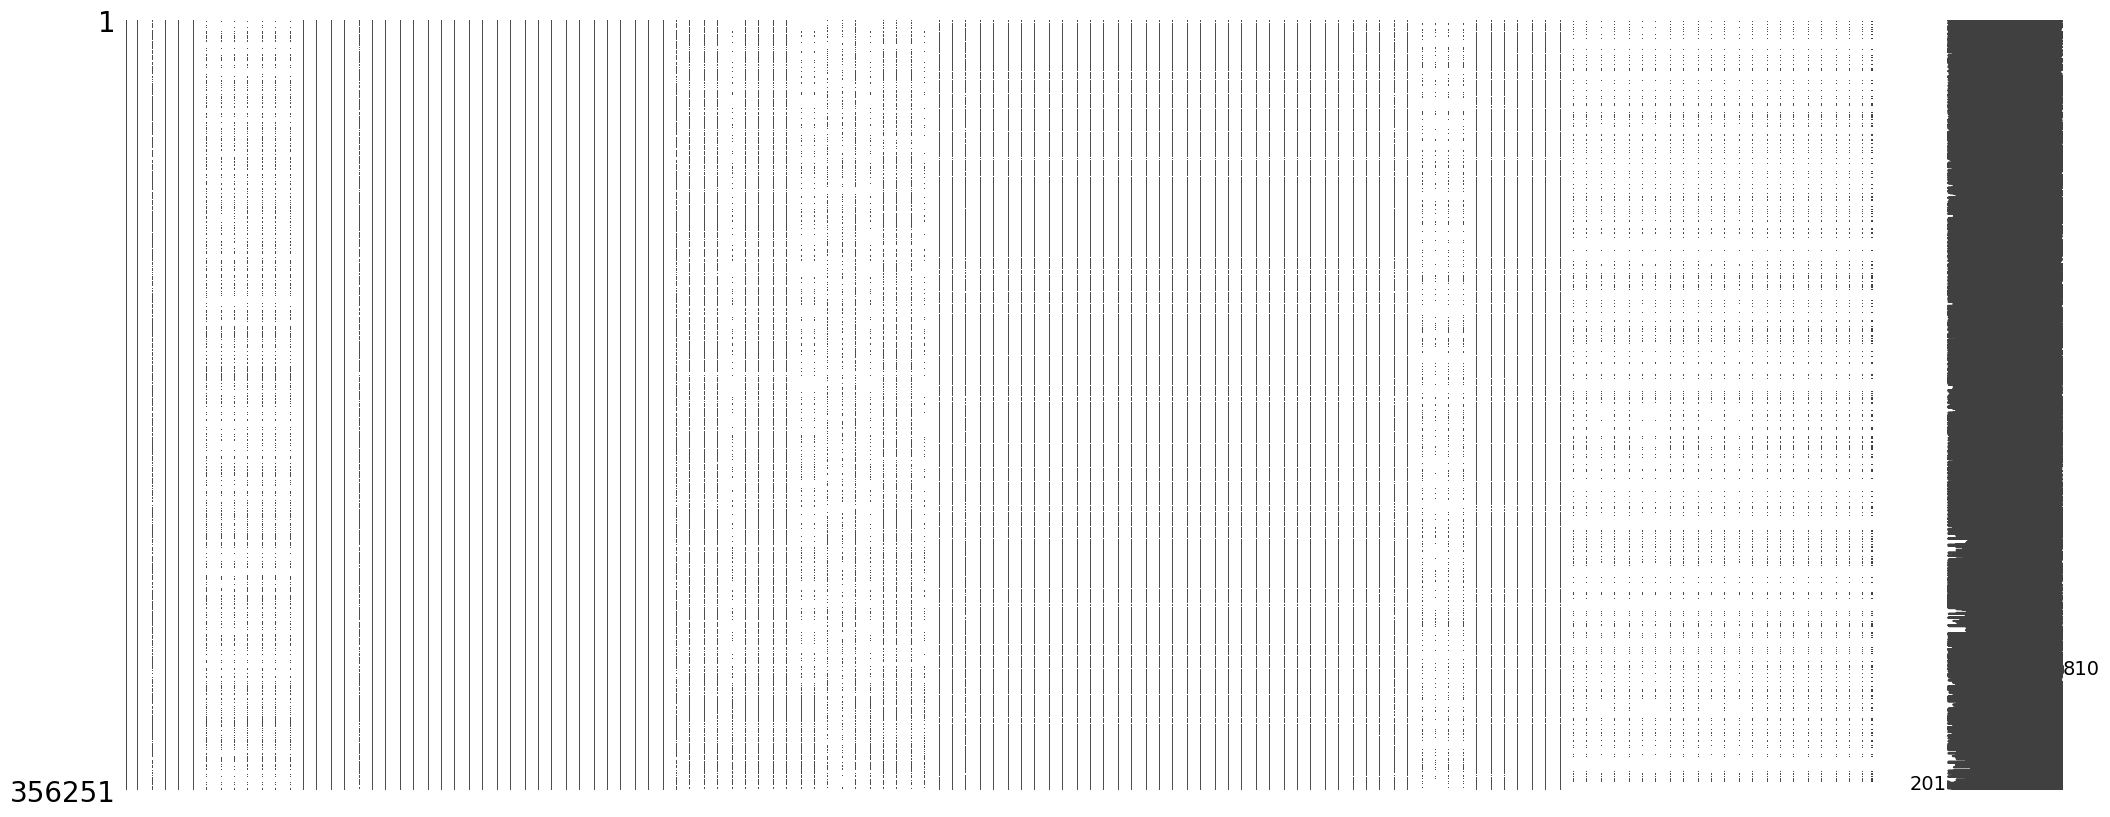

In [ ]:
import missingno as msno

# Assuming your DataFrame is named 'df'
msno.matrix(df)
plt.show()

In [ ]:
df.isnull()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
1,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
2,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,False,True,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
48740,False,True,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
48741,False,True,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
48742,False,True,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True


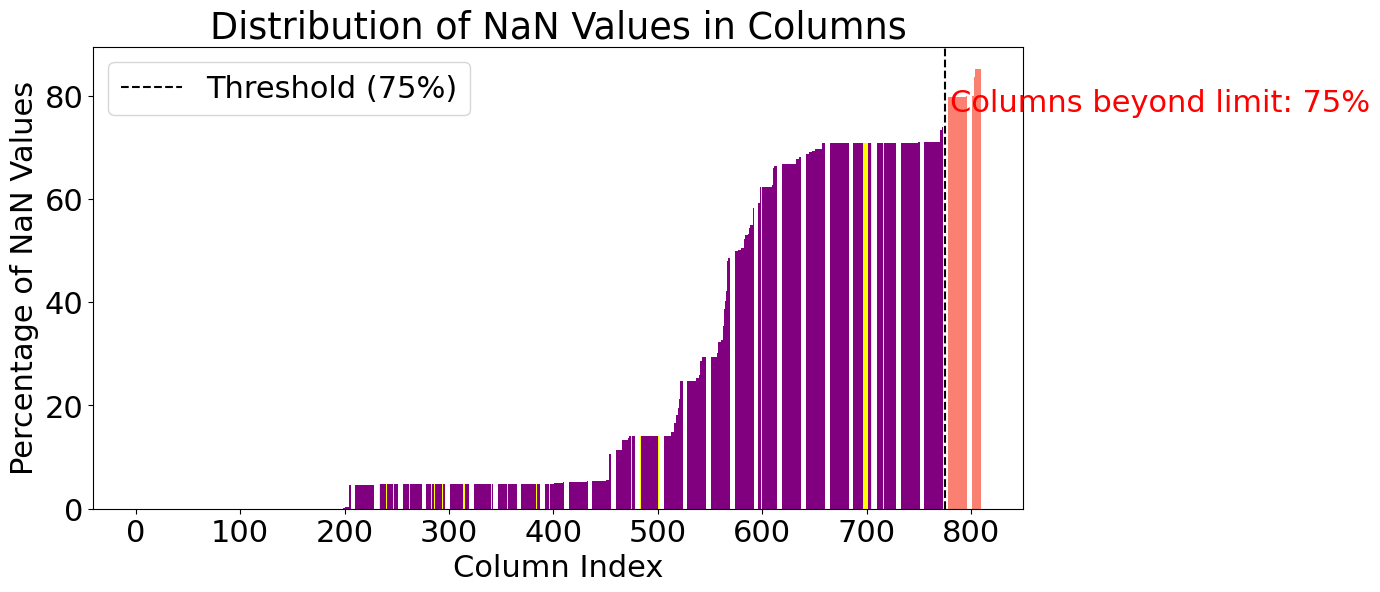

Number of features having NAN values rate lower than 75% is 775:


In [ ]:
# Assuming your DataFrame is named df
# Drop columns with unique values
unique_columns = df.loc[:, df.nunique() == 1]

# Generate a DataFrame containing the NaN values (True if NaN, False otherwise)
nan_values = df.isnull()

# Calculate the percentage of NaN values in each column
nan_percentage = (nan_values.sum() / len(df)) * 100

# Sort columns based on the percentage of NaN values in ascending order
sorted_columns = nan_percentage.sort_values(ascending=True).index

# Set a threshold for displaying columns
threshold = 75

# Filter columns with NaN percentage above the threshold
#columns_to_display = nan_percentage[nan_percentage < threshold].index.difference(unique_columns.columns)
columns_to_display = nan_percentage[nan_percentage < threshold]
columns_beyond_limit = nan_percentage[nan_percentage >= threshold].index

# Plot the NaN values distribution using a bar plot
plt.figure(figsize=(12, 6))

# Assign different colors to columns
colors = ['yellow' if col in unique_columns.columns else 'purple' if col in columns_to_display else 'salmon' for col in sorted_columns]

plt.bar(range(len(sorted_columns)), nan_percentage[sorted_columns], color=colors)

# Add a vertical line to indicate the threshold
plt.axvline(x=len(columns_to_display), color='black', linestyle='--', label=f'Threshold ({threshold}%)')

# Add text to show the count of columns beyond the limit
plt.text(len(columns_to_display) + 5, threshold + 2, f'Columns beyond limit: {threshold}%', color='red')

plt.xlabel('Column Index')
plt.ylabel('Percentage of NaN Values')
plt.title('Distribution of NaN Values in Columns')
plt.legend()
plt.show()

# Create a dictionary mapping column names to their positions
column_positions = {col: i for i, col in enumerate(sorted_columns)}

# Number of features selected for the analysis
print('Number of features having NAN values rate lower than {}% is {}:'.format(threshold, len(columns_to_display)))

# Create a subset DataFrame with only the selected columns
subset_df = df[columns_to_display.index.difference(unique_columns.columns)]


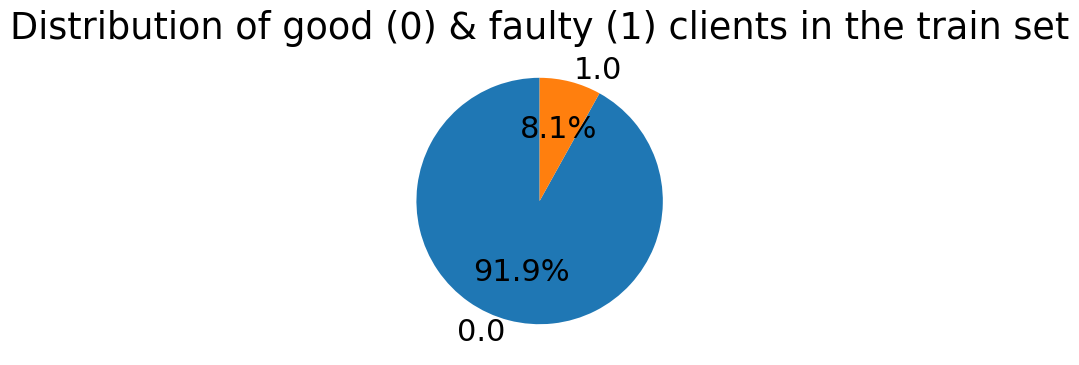

In [ ]:
value_counts = subset_df.TARGET.value_counts()

plt.figure(figsize=(4, 4))
value_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Distribution of good (0) & faulty (1) clients in the train set')
plt.ylabel('')
plt.show()

# Imputation NAN/INF

Numerical features:
* NAN ----> Median
* +/-INF ----> +/- max(abs())

Categorical features:
* NAN ----> most frequent

In [ ]:
from sklearn.impute import SimpleImputer

def preprocessor(df_):
    X = df_.drop(['TARGET','SK_ID_CURR'], axis=1)

    # Get numeric columns not in categorical_cols
    numeric_cols = X.select_dtypes(include='number').columns.difference(categ_cols)
    #categorical_cols = X.select_dtypes(exclude=['number']).columns
    categorical_cols = categ_cols + X.select_dtypes(exclude=['number']).columns.tolist()
    categorical_cols = [col for col in categorical_cols if col in X.columns]

    # Identify columns with unique values and/or NaN values
    unique_nan_cols = [col for col in X.columns if X[col].nunique() == X[col].notna().sum() + X[col].isna().sum()]

    # Drop columns with only 0 and NaN values
    X = X.drop(columns=unique_nan_cols)

    # Print the identified columns
    print("Columns with unique values and NaN values:", unique_nan_cols)

    ## Handle NaN values differently for numeric and categorical columns
    numeric_transformer = SimpleImputer(strategy='median', missing_values=np.nan)
    categorical_transformer = SimpleImputer(strategy='most_frequent', missing_values=np.nan)

    # replace INF values by +/-max(bas)
    # Loop over columns with inf values and apply replacement
    print( X.columns)
    for column in X.columns:
        if np.any(np.isinf(X[column])):
            max_abs_value = np.nanmax(np.abs(X[column][~np.isinf(X[column])]))
            X[column].replace([np.inf, -np.inf], [max_abs_value, -max_abs_value], inplace=True)
    
    X[numeric_cols] = numeric_transformer.fit_transform(X[numeric_cols])

    if categorical_cols != []:
        X[categorical_cols] = categorical_transformer.fit_transform(X[categorical_cols])

    # Apply additional preprocessing steps if needed, such as scaling numeric features       
    scaler = StandardScaler()
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
    X = pd.concat([df_[['TARGET', 'SK_ID_CURR']], X], axis=1)

    return X

# Save Engineered Features

In [11]:
pd.read_csv('train_df_cleaned.csv', index_col=0).shape

(307507, 741)

In [ ]:
# Divide in training/validation and test data
cleaned_subset_sf = preprocessor(subset_df)
train_df = cleaned_subset_sf[cleaned_subset_sf['TARGET'].notnull()]
test_df = cleaned_subset_sf[cleaned_subset_sf['TARGET'].isnull()]
test_df.to_csv('test_df_cleaned.csv')
train_df.to_csv('train_df_cleaned.csv')
train_df.sample(7000).to_csv('train_df_cleaned_sample_7000.csv')

Columns with unique values and NaN values: []
Index(['ACTIVE_AMT_ANNUITY_MAX', 'ACTIVE_AMT_ANNUITY_MEAN',
       'ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN', 'ACTIVE_AMT_CREDIT_SUM_DEBT_MAX',
       'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN', 'ACTIVE_AMT_CREDIT_SUM_DEBT_SUM',
       'ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN', 'ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM',
       'ACTIVE_AMT_CREDIT_SUM_MAX', 'ACTIVE_AMT_CREDIT_SUM_MEAN',
       ...
       'WEEKDAY_APPR_PROCESS_START_SUNDAY',
       'WEEKDAY_APPR_PROCESS_START_THURSDAY',
       'WEEKDAY_APPR_PROCESS_START_TUESDAY',
       'WEEKDAY_APPR_PROCESS_START_WEDNESDAY', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BUILD_AVG', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE'],
      dtype='object', length=739)


In [9]:
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

to_drop = ['TARGET','SK_ID_CURR']

train_df_sample = pd.read_csv('train_df_cleaned.csv', index_col=0).drop(to_drop, axis=1).sample(50)
df_test_sample = pd.read_csv('test_df_cleaned.csv').drop(to_drop, axis=1).sample(50)

data_drift_report = Report(metrics=[DataDriftPreset(),])
print('data_drift_report OK')
data_drift_report.run(current_data=df_test_sample, reference_data=train_df_sample, column_mapping=None)
print('data_drift_report RUN')
data_drift_report.save_html("data_drift_report_sample.html")
print('data_drift_report Saved')

data_drift_report OK
data_drift_report RUN
data_drift_report Saved
